# Trial for own CNN w/ pixel-targeting

----


In [2]:
import random
import numpy as np
import pandas as pd

import json
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
import time

import tensorflow as tf
from keras import models, layers, optimizers, losses, metrics
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array

2022-06-08 16:25:40.929278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 16:25:40.929322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


-------------------------
# Import data

----


## Loading the Image

In [328]:
# Data sources
path_raw_data = 'Potsdam_v02_small/'
name_raw_data = 'Potsdam02s'
raw_image_number = 0

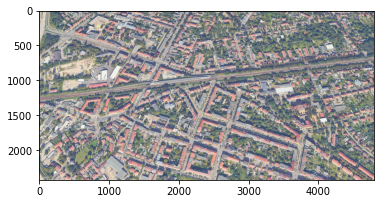

In [30]:
# load the image to get its shape
orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
i_width, i_height = orig_image.size
# convert to numpy array
image = img_to_array(orig_image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

plt.imshow(orig_image)

## Loading the label-points for the picture from label studio

In [31]:
# load json
with open(f'{path_raw_data}{name_raw_data}.json', 'r') as json_file:
	json_load = json.load(json_file)

# select data
json_load = json_load[raw_image_number]["annotations"][0]["result"]
labels_x = ([])
labels_y = ([])
for i in json_load:
        labels_x = np.append(labels_x, i["value"]["x"])
        labels_y = np.append(labels_y, i["value"]["y"])

labels_unscaled = np.vstack((labels_x, labels_y)).transpose()
print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")
labels_unscaled.dtype

There are (1383,) labeled trees in the picture


dtype('float64')

The image size is 4800x2427 pixels.
The 1383 datapoints are distributed along the respective axis as follows:


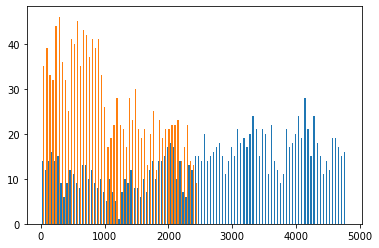

In [39]:
# scale datapoints to image pixels
reshaper = [[(i_width/100), 0], [0,(i_height/100)]]
labels = np.mat(labels_unscaled) * np.mat(reshaper)
# check label positions
histogram_labels = plt.hist(labels, bins=100)
print(f"The image size is {i_width}x{i_height} pixels.")
print(f"The {len(labels_x)} datapoints are distributed along the respective axis as follows:")

Matching Image and labels and show upload result

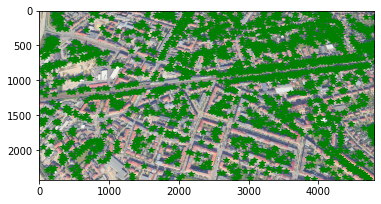

In [41]:
plt.imshow(orig_image)

# plot each labeled tree
for dot in labels:
    #print(dot[:,1])
    plt.plot(dot[:,0], dot[:,1], marker='*', color="green")
# show the plot
plt.show()

## Prepare tiles

Tiles = child-pictures of image, all together represent the whole image
- split the picture into quadratic tiles of equal size

In [309]:
# define the tile size
tile_size = 30
num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image = np.array(image) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_info = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting (left/top) & mean pixels in rows and columns for this tile
        v_start = i * tile_size
        h_start = j * tile_size
        v_mean = v_start + tile_size // 2
        h_mean = h_start + tile_size // 2
        # create tile
        tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_info[tile_num] = (i,j,0,0,v_mean, h_mean)

print(f"Tiles are created: {tiles.shape}.")

There are 12800 tiles at 30x30 pixels
There are 160 horizontal tile columns and 80 vertical tile rows


100%|██████████| 80/80 [00:00<00:00, 643.70it/s]

Tiles are created: (12800, 30, 30, 3).


In [310]:
# Labeling the tiles
tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
tile_count = np.zeros((num_tiles, 1)) # number of trees in each tile
label_count = 0

for label in labels:
    pos_horizontal = label[:,0] // tile_size -1
    pos_vertical = label[:,1] // tile_size -1
    tile_num = int(pos_vertical * num_horizontal_tiles + pos_horizontal)
    tile_labels[tile_num] = 1
    tile_count[tile_num] += 1
    tile_info[tile_num][2]= 1
    label_count += 1

print(f"Labels vector is created over all tiles: {tile_labels.shape}.")
print(f"Tiles labeled as with tree: {tile_labels.sum()}")
print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
print(f"Total trees assigned: {tile_count.sum()}.")

Labels vector is created over all tiles: (12800, 1).
Tiles labeled as with tree: 1360.0
This is 10.625% of the tiles.
Total trees assigned: 1383.0.


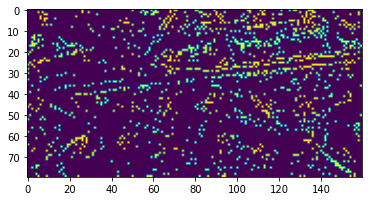

In [296]:
# show labeled tiles
tiles_show = tile_info[:,2].reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

The max number of trees per tile is: 2.0
The distribution number of trees per tile is:


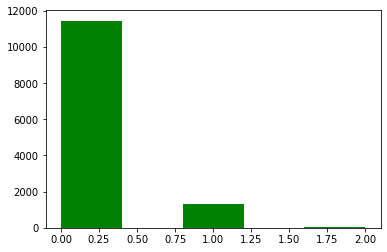

In [297]:
# max count tile show
print(f"The max number of trees per tile is: {tile_count.max()}")
plt.hist(tile_count, bins=5, color="green")
print("The distribution number of trees per tile is:")

tile_num is: 11505
column: 145 of 160, row: 71 of 80
Tile label: [1.]
Tile tree count: [1.]


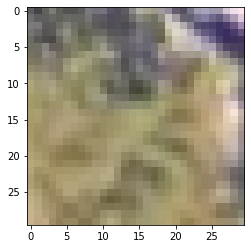

In [298]:
example = random.randint(0, num_tiles-1)
print(f"tile_num is: {example}")
print(f"column: {example % num_horizontal_tiles} of {num_horizontal_tiles}, row: {example // num_horizontal_tiles} of {num_vertical_tiles}")
print(f"Tile label: {tile_labels[example]}")
print(f"Tile tree count: {tile_count[example]}")
plt.imshow(tiles[example])
plt.show()

## Prepare training and validation set

In [299]:
# split the tiles into training and validation set
train_split = 0.8

train_tiles = tiles[:int(num_tiles*train_split)]
train_labels = tile_labels[:int(num_tiles*train_split)]
val_tiles = tiles[int(num_tiles*train_split):]
val_labels = tile_labels[int(num_tiles*train_split):]
print(f"Training set: {train_tiles.shape} - ({train_split} share of all tiles)")
print(f"Validation set: {val_tiles.shape}")

Training set: (10240, 30, 30, 3) - (0.8 share of all tiles)
Validation set: (2560, 30, 30, 3)


In [106]:
# build tensorflow dataset
dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

2022-06-08 16:52:09.839665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 16:52:09.839704: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 16:52:09.839733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Luise): /proc/driver/nvidia/version does not exist
2022-06-08 16:52:09.841668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 16:52:09.844583: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 221184000 exceeds 10%

In [107]:
def encode(tile, label):
    image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
    image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
    return image_encoded, label

batch_size = 32
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(25).batch(batch_size)
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

-------
# Training

----



## model


In [108]:
model = models.Sequential()
initializer = tf.keras.initializers.GlorotUniform(seed=42)
model.add(layers.Input(shape=(tile_size, tile_size, 3)))

model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
model.add(layers.ZeroPadding2D(padding=(2,2), data_format=None))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
model.add(layers.ZeroPadding2D(padding=(1, 1), data_format=None))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=initializer))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 20)        560       
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 20)       0         
 2D)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 30)        5430      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 19, 19, 30)       0         
 ng2D)                                                           
                                                        

## Train a model

In [109]:
model_name = "02"
epochs = 20

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate,
)

Epoch 1/20


2022-06-08 16:52:30.980088: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 221184000 exceeds 10% of free system memory.
/home/luise/Documents/DataScience/Projects/UrbanEagle/urbaneagle_visionai/venv/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


320/320 [==============================] - 7s 19ms/step - loss: 0.3513 - binary_accuracy: 0.8838 - val_loss: 0.2604 - val_binary_accuracy: 0.9238
Epoch 2/20
320/320 [==============================] - 5s 16ms/step - loss: 0.3379 - binary_accuracy: 0.8862 - val_loss: 0.2575 - val_binary_accuracy: 0.9238
Epoch 3/20
320/320 [==============================] - 6s 18ms/step - loss: 0.3348 - binary_accuracy: 0.8862 - val_loss: 0.2563 - val_binary_accuracy: 0.9238
Epoch 4/20
320/320 [==============================] - 5s 17ms/step - loss: 0.3323 - binary_accuracy: 0.8862 - val_loss: 0.2565 - val_binary_accuracy: 0.9238
Epoch 5/20
320/320 [==============================] - 6s 18ms/step - loss: 0.3299 - binary_accuracy: 0.8862 - val_loss: 0.2556 - val_binary_accuracy: 0.9238
Epoch 6/20
320/320 [==============================] - 6s 18ms/step - loss: 0.3287 - binary_accuracy: 0.8862 - val_loss: 0.2535 - val_binary_accuracy: 0.9238
Epoch 7/20
320/320 [==============================] - 6s 17ms/step - 

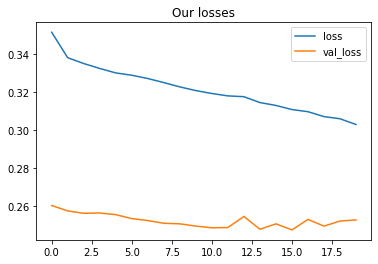

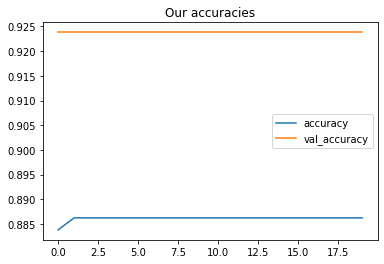

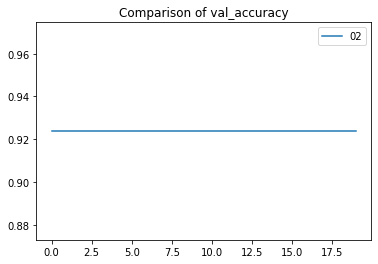

In [110]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["binary_accuracy"], label="accuracy")
    plt.plot(history["val_binary_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

history_list = {}
history_list[model_name] = history.history
render_history(history.history)
compare_histories()
tf.keras.backend.clear_session()

-------------------------
# Predict

-----

## predict on training data

In [300]:
# predict
threshold = 0.3
probabilities = model.predict(tiles)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]

400/400 [==============================] - 2s 6ms/step


In [301]:
#count true predictions
true_predictions = sum(1 if x == y else 0 for x, y in zip(predictions, tile_labels))
true_predictions_count = sum(true_predictions)
print(f"True trees: {tile_count.sum()}")
print(f"Predictions: {true_predictions_count} out of {len(predictions)} tiles are identified as with trees.")

True trees: 1383.0
Predictions: 11378 out of 12800 tiles are identified as with trees.


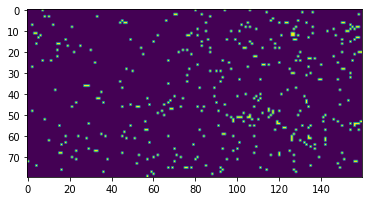

In [316]:
# show labeled tiles
tiles_show = predictions.reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

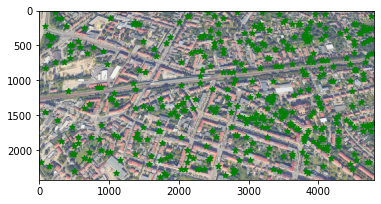

In [324]:
# get pixels for predicted trees
plt.imshow(orig_image)
# plot each labeled tree
for tree in tile_info:
    if tree[3] >= threshold:
        plt.scatter(tree[5], tree[4], marker='*',  c="green")
    #plt.plot(tile[0], tile[1], marker='*', color="green")
plt.show()

Save predictions


In [325]:
# save predictions
np.savetxt(f'predictions_{name_raw_data}_{model}.txt', predictions)

## Test on images

In [337]:
# load the image to get its shape
name_raw_data = "Potsdam_02"
orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
i_width, i_height = orig_image.size
# convert to numpy array
image = img_to_array(orig_image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

In [338]:
# define the tile size
tile_size = 30
num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image = np.array(image) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_info = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting (left/top) & mean pixels in rows and columns for this tile
        v_start = i * tile_size
        h_start = j * tile_size
        v_mean = v_start + tile_size // 2
        h_mean = h_start + tile_size // 2
        # create tile
        tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_info[tile_num] = (i,j,0,0,v_mean, h_mean)

print(f"Tiles are created: {tiles.shape}.")

There are 12800 tiles at 30x30 pixels
There are 160 horizontal tile columns and 80 vertical tile rows


100%|██████████| 80/80 [00:00<00:00, 675.19it/s]

Tiles are created: (12800, 30, 30, 3).


400/400 [==============================] - 3s 7ms/step


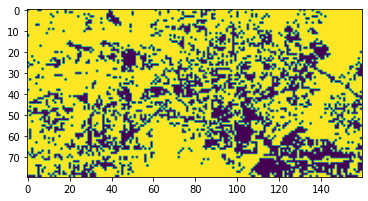

In [339]:
# predict
threshold = 0.3
probabilities = model.predict(tiles)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]
#count true predictions
true_predictions = sum(1 if x == y else 0 for x, y in zip(predictions, tile_labels))
#true_predictions_count = sum(true_predictions)
#print(f"True trees: {tile_count.sum()}")
#print(f"Predictions: {true_predictions_count} out of {len(predictions)} tiles are identified as with trees.")
# show labeled tiles
tiles_show = predictions.reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

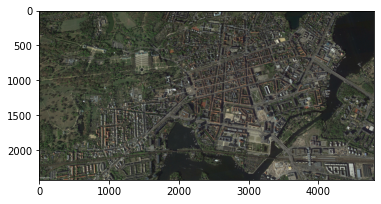

In [340]:
plt.imshow(orig_image)